# Ch3. word2vec

### Recap [Ch 2. 단어의 분산 표현]

- 통계 기반 기법 : 단어의 빈도를 가지고 표현
- **추론 기반 기법**

### 이번 장에서 배울 내용

- 추론 기반 기법은 추측하는 것이 목적이며, 그 부산물로 단어의 분산 표현을 얻을 수 있다.
- word2vec은 추론 기반 기법이며, 단순한 2층 신경망이다.
- word2vec은 skip-gram 모델과 CBOW 모델을 제공한다.
- CBOW 모델은 여러 단어(맥락)로부터 하나의 단어(타깃)를 추측한다.
- 반대로 skip-gram 모델은 하나의 단어(타깃)로부터 다수의 단어(맥락)을 추측한다.
- word2vec은 가중치를 다시 학습할 수 있으므로, 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행할 수 있다.

### 추론 기반 기법이란?
   - 추론 하는 기법
   - 대표적으로 신경망을 이용한 **word2vec** 이 이에 해당한다.

### 이번장에서 다룰 내용

- word2vec의 구조
- '단순한' word2vec 구현
    - Ch4에서 '진짜' word2vec을 완성할 예정


## 3.1 추론 기반 기법과 신경망

단어를 벡터로 표현하는 방법은 지금까지 활발히 연구되었으며, 그중에서도 성공적인 기법들은 크게 두 부류로 나눌 수 있다.

- **통계 기반 기법**
- **추론 기반 기법**

차이점 : 단어의 의미를 얻는 방식  
공통점 : 분포 가설을 가짐 ?? 어떤 의미인가

 이번 절에서는 통계 기반 기법의 문제를 지적하고, 그 대안인 추론 기반 기법의 이점을 거시적인 관점에서 설명한다. 그 이후 `word2vec`의 전처리를 위해 신경망으로 '단어'를 처리하는 예를 확인해보자.

### 3.3.1 통계 기반 기법의 문제점

#### 계산 복잡도

통계 기반 기법은 주변 단어의 빈도를 기초로 단어를 표현했다. 구체적으로는 단어의 동시발생 행렬을 만들고 그 행렬을 만들고 그 행렬에 **SVD**를 적용하여 밀집벡터(단어의 분산 표현)를 얻었다. 그러나 이 방식은 대규모 말뭉치를 다룰 때 문제가 발생한다.

현실에서 다루는 말뭉치의 어휘 수는 무수히 많다. 예를 들어 영어의 어휘 수는 100만을 넘는다고 하는데, 통계 기반 기법에서는 형상이 `100만 x 100만`인 행렬을 만들게 된다. 이런 거대 행렬에 **SVD** 기법을 적용하는 것은 현실적이지 않다.

> **NOTE**  
> SVD를 $n \times n$ 행렬에 적용하는 비용은 $Q(n^{n})$이다. 슈퍼컴퓨터로 동원해도 처리할 수 없는 수준이라고 한다. 근사적인 기법?과 희소행렬의 성질 등을 이용해 속도를 개선할 수 있다고 한다. 하지만 여전히 상당한 컴퓨팅 자원을 들여 장시간 계산해야 한다.


<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-1.png?raw=False" width="700">

### 3.1.2 추론 기반 기법 개요

**[그림 3-2]** 처럼 주변 단어(맥락)가 주어졌을 때 "?"에 무슨 단어가 들어가는지 추측하는 작업

**[그림 3-2]** 주변 단어들을 맥락으로 사용해 "?"에 들어갈 단어를 추측한다.

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-2.png?raw=true" width="700">


위처럼 추론 문제를 풀고 학습하는 것이 '추론 기반 기법'이 다루는 문제이다. 이러한 추론 문제를 계속해서 반복하면서 단어의 출현 패턴을 학습하는 것이다. '모델 관점'에서 보면, 이 추론 문제는 **[그림 3-3]**처럼 보인다.

**[그림 3-3]** 추론 기반 기법 : 맥락을 입력하면 모델은 각 단어의 출현 확률을 출력한다.

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-3.png?raw=true" width="700">

위 처럼 추론 기반 기법에는 어떠한 모델이 등장한다. 이 모델로 신경망을 사용하며, 모델은 맥락 정보를 입력받아 (출현할 수 있는) 각 단어의 출현 확률을 출력한다. 

> **NOTE**  
> 추론 기반 기법도 통계 기반 기법처럼 분포 가설에 기초하게 된다. **분포 가설이란?** **"단어의 의미는 주변 단어에 의해 형성된다."**는 가설로, 추론 기반 기법에서는 이를 앞에서와 같은 추측 문제로 귀결시켰다. 이 처럼 두 기법 모두 분포 가설 근거하는 **'단어의 동시발생 가능성'**을 얼마나 잘 모델링 하는가 중요한 연구 주제이다.

### 3.1.3 신경망에서의 단어 처리

신경망을 이용해 '단어'를 처리한다. 하지만, 신경망은 'you'와 'say' 등의 단어를 있는 그대로 처리할 수 없으니 단어를 '고정 길이의 벡터'로 변환해야 한다. 이때 사용하는 방법이 단어를 **원핫 표현(원핫 벡터)**으로 변환하는 것이다.

**[그림 3-4]** : 단어, 단어 ID, 원핫 표현

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-4.png?raw=true" width="700">

이를 통해 얻는 이점은 신경망의 입력층을 **[그림 3-5]**처럼 뉴런의 수를 **"고정"** 할 수 있다.

**[그림 3-5]** : 입력층의 뉴런 : 각 뉴런이 각 단어에 대응(해당 뉴런이 1이면 파랑색, 0이면 회색)

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-5.png?raw=true" width="700">

**[그림 3-6]** : 완전연결계층에 의한 변환 : 입력층의 각 뉴런은 7개의 단어 각각에 대응(은닉층 뉴런은 3개를 준비함)

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-6.png?raw=true" width="500">

**[그림 3-7]** : 완전연결계층에 의한 변환을 단순화한 그림(완전연결계층의 가중치를 7 x 3 크기의 **W**라는 행렬로 표현)

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-7.png?raw=true" width="400">

In [29]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 입력
W = np.random.randn(7, 3)              # 가중치
h = np.matmul(c, W)                    # 중간노드
print(h)

[[-0.4667919  -0.15521221  0.71910488]]


> **Warning**  
> 이 코드에서는 입력 데이터(c)의 차원 수(ndim)은 2이다. 이는 미니배치 처리를 고려한 것으로 최초의 차원(0번째 차원)에 각 데이터를 저장한다.

In [30]:
np.ndim(c)

2

**[그림 3-8]** : 맥락 **c**와 **W**의 곱으로 해당 위치의 행벡터가 추출된다. (각 요소의 가중치 크기는 흑백의 진하기로 표현)

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-8.png?raw=true" width="600">

In [31]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.30099578  0.75962401 -0.05954486]]


---

## 3.2 단순한 word2vec

- word2vec 구현!

**[그림 3-3]**의 '모델'을 신경망으로 구축해보자.

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-3.png?raw=true" width="700">

 이번절에서는 **word2vec**에서의 **CBOW(continuous bag-of-words)** 모델이다.
 
 > **Warning**  
 > word2vec이라는 용어는 원래 프로그램이나 도구를 가리키는 데 사용됐습니다. 그런데 이 용어가 유명해지면서, 문맥에 따라서는 신경망 모델을 가리키는 경우도 많이 볼 수 있습니다. **CBOW** 모델과 **Skip-gram** 모델은 **word2vec**에서 사용되는 신경망입니다. 이번 절에서는 **CBOW** 모델을 중심으로 이야기를 풀어가며, 두 모델의 차이는 '3.5.2. skip-gram 모델'절에서 자세히 설명하겠습니다.

### 3.2.1 CBOW 모델의 추론 처리

맥락으로부터 **Target**을 추측하는 용도의 신경망이다. ('타깃'은 중앙 단어이고 그 주변 단어들이 '맥락'입니다.). 이 **CBOW** 모델이 가능한 한 정확하게 추론하도록 훈련시켜서 단어의 분산 표현을 얻어낼 것이다.

**CBOW** 모델의 입력은 맥락입니다. 
- 맥락 : "you", "goodbye"
- 타겟 : ?

**[그림 3-9]** **CBOW**모델의 신경망 구조

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%203-9.png?raw=true" width="500">

> **Warning**  
> 이 그림에서 입력층이 2개인 이유는 맥락으로 고려할 단어를 2개로 정했기 때문이다. 즉, 맥락에 포함시킬 단어가 $N$개라면 입력층도 $N$가 된다.

입력이 여러 개이면 전체를 **평균**하면 된다. 앞의 예에 대입해보면 다음과 같다. 완전연결계층에 의한 첫 번째 입력층이 $h_1$으로 변환되고, 두 번째 입력층이 $h_2$로 변환되었다고 하면, 은닉층 뉴런은 $\frac{1}{2}(h_1 + h_2)$가 되는 것이다.

마지막으로  **[그림 3-9]**의 출력층을 보면, 출력층의 뉴런은 총 7개인데, 여기서 중요한 것은 이 뉴런 하나하나가 각각의 단어에 대응한다는 것이다. 그리고 출력층 뉴런은 각 던어의 **'점수'**를 뜻하며, 값이 높을수록 대응 단어의 출현 확률도 높아진다. 여기서 점수란 확률로 해석되기 전의 값이고, 이 점수에 소프트맥스 함수를 적용해서 '확률'로 얻을 수 있다.

> **Warning**  
> 점수를 **Softmax** 계층에 통과시킨 후의 뉴런을 '출력층'이라고도 한다. 교재에서는 점수를 출력하는 노드를 '출력층'이라고 하자.

**[그림 3-10]** 가중치의 각 행이 해당 단어의 분산 표현이다.

가중치 $\text{W}_{in}$의 각 행에는 해당 단어의 분산 표현이 담겨 있다고 볼 수 있다. 따라서, 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산 표현들이 업데이트 될 것이다. 학습을 할수록 놀랍게도 이렇게 해서 얻은 벡터에는 "단어의 의미"도 잘 녹아들어 있다! ?

- decoding : 인간이 이해할 수 있는 입력 데이터를 이해할 수 없는 은닉층의 정보로 바꾸어주는 작업
- encoding : 인간이 이해할 수 없는 코드를 이해할 수 있는 정보로 표현해주는 작업

**[그림 3-11]** 계층 관점에서 본 **CBOW** 모델의 신경망 구성 : **MatMul** 계층에서 사용하는 가중치 ($W_{in}$, $W_{out}$)는 해당 계층 안으로 넣었음 

In [32]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer0.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.34904478  1.8836168  -2.3177639   0.86041322  1.67115259  0.91829777
   0.25762952]]


- 가중치 초기화
- 입력층 2개 생성
- 출력 계층 1개 생성
- $W_{in}$을 공유함

### 3.2.2 CBOW 모델의 학습

**[그림 3-12]** **CBOW** 모델의 구체적인 예(노드 값의 크기를 흑백의 진하기로 나타냄)

지금까지 모델을 통해 출력층에서 각 단어의 점수(Score)를 출력했다. 이 점수에 소프트맥스 함수를 적용하면 "확률"을 얻을 수 있다. 이 확률은 맥락(전후 단어)이 주어졌을 때 그 가운데 어떤 단어가 출현하는지 나타낸다.

모델을 학습시키는 데이터 셋에 따라서 단어의 분산 표현은 다를 수 밖에 없다.

이제 학습은 기존 신경망을 학습시키는 방법과 똑같다. 즉, 소프트맥스와 교차 엔트로피 오차만 적용하면 된다.

### 3.2.3 word2vec의 가중치와 분산 표현

**word2vec**에서 사용되는 신경망의 가중치는 다음과 같다

- $W_{in}$ : 입력 ~ Layer
- $W_{out}$ : Layer ~ 출력

우선 입력 측 가중치 $W_{in}$가 각 행이 word2vec모델에서 사용되는 단어의 분산 표현에 해당한다.

형상을 확인해보면서 비교해보자.


위의 형상을 보고 단어의 분산 표현으로는 어느 쪽 가중치를 선택하면 좋을까?

- **A** : 입력 측의 가중치만 이용
- **B** : 출력 측의 가중치만 이용
- **C** : 입력 및 출력 모든 가중치 이용

**word2vec**(특히 **skip-gram** 모델)에서는 **A** 안인 "입력 측의 가중치만 이용한다."가 가장 대중적인 선택이다. 많은 연구에서도 그렇게 해왔으므로, 이를 따라서 $W_{in}$을 단어의 분산 표현으로 이용하겠다.

---

## 3.3 학습 데이터 준비


> "You say goodbye and I say hello."

### 3.3.1 맥락과 타깃

입력은 "맥락", 정답 레이블은 맥락에 둘러싸인 "중안의 단어", 즉, "타깃"  
목표는 신경망에 "맥락"을 입력했을 때 "타깃"이 출현할 확률을 높이는 것!

**[그림 3-16]** 말뭉치에서 맥락과 타깃을 만드는 예

말뭉치로부터 맥락과 타깃을 만드는 함수 구현 필요, 우선 말뭉치 텍스트를 단어 ID로 변환해야 한다.

In [33]:
import sys
sys.path.append("..")
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(word_to_id)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


그런 다음 **"단어 ID"**의 배열인 corpus(문장)로부터 맥락과 타깃을 만들어야 한다.  
함수 **`create_contexts_target()`**을 확인해보자.

In [34]:
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size: -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size): # [1, 2, 3, 4, 5, 6]
        cs = []
        for t in range(-window_size, window_size + 1):  # [-1, 0, 1]
            if t == 0: # target
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [35]:
contexts, target = create_contexts_target(corpus, window_size = 1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


이것으로 말뭉치로부터 맥락과 타깃을 만들었다. 나중에 이를 **CBOW** 모델에 넘겨주면 된다. 하지만, 위의 맥락과 타깃을 보면 **단어 ID**로 출력된다.  
이를 **One-Hot 표현**으로 변환이 필요하다

### 3.3.2 원핫 표현으로 변환

**[그림 3-18]** "맥락"과 "타깃"을 원핫 표현으로 변환하는 예시

In [36]:
import sys
sys.path.append("..")
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [37]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [38]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## 3.4 CBOW 모델 구현

**[그림 3-19]** CBOW 모델의 신경망 구성


함수 simpleCBOW()라는 이름으로 구현해보자.

In [39]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.ㄴ, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        #  인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

**forward()**
> 기능 : 인수로 맥락(contexts)과 타깃(target)을 받아 손실(loss)를 반환

In [40]:
def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:,0])
    h1 = self.in_layer1.forward(contexts[:,1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

**contexts** : 3차원 Numpy array  (6, 2, 7)

**backward()**
> 

In [41]:
def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

### 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 261 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 262 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 263 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 264 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 265 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 266 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 267 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 268 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 269 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 270 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 271 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 272 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 273 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 274 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 275 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 276 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 277 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 278 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 279 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 280 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 281 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 282 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 283 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 284 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 285 |  반복 1

| 에폭 519 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 520 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 521 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 522 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 523 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 524 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 525 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 526 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 527 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 528 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 529 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 530 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 531 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 532 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 533 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 534 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 535 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 536 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 537 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 538 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 539 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 540 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 541 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 542 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 543 |  반복 1

| 에폭 797 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 798 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 799 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 800 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 801 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 802 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 803 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 804 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 805 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 806 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 807 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 808 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 809 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 810 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 811 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 812 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 813 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 814 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 815 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 816 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 817 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 818 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 819 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 820 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 821 |  반복 1

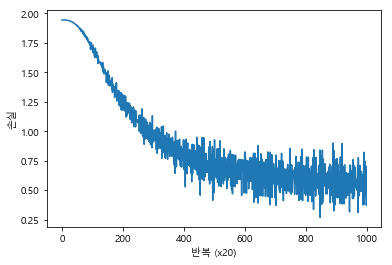

In [42]:
from matplotlib import font_manager, rc, rcParams
rcParams['axes.unicode_minus'] = False
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5 # 변경 조절! (위의 설명에서는 3으로 가정)
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

### 학습이 끝난 후의 가중치 매개변수를 살펴보자

- 확인 방법 : 입력 측 MatMul 계층의 가중치는 인스턴스 변수 **`word_vecs`**에 저장되어 있으니, 앞의 코드 바로 뒤에 다음 코드를 추가해보자.

- $W_{in}$ : 형상(shape)는 ? 말뭉치 내 단어가 7개이며, hidden_size = 5를 상기시키자.

In [28]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.6445006 -0.8587952 -1.18027    0.8912136  0.7656978]
say [-0.33585444  0.1700082  -0.12820265 -1.2794447  -1.2781273 ]
goodbye [ 0.5088923 -1.1433746 -0.6126154  1.0477554  1.1041275]
and [-1.2747562 -1.5306194  1.4416305 -1.1230078 -1.1405797]
i [ 0.5087879  -1.1225271  -0.61499894  1.0432854   1.0902872 ]
hello [-1.6505892  -0.86641145 -1.1658508   0.88739467  0.7772721 ]
. [ 1.2566293  1.2034748 -1.2383404 -1.0880569 -1.0844823]


각 단어마다 밀집벡터로 나태낼 수 있게 되었다. 이 단어에 해당하는 벡터 하나가 바로 단어의 **분산 표현**이다.

하지만, 아쉽게도 여기서 다룬 작은 말뭉치로는 좋은 결과를 얻을 수 없었다. 이유 : 데이터가 작기 때문에.. 또한 실용적이고 충분히 큰 말뭉치로 바꾸면 좋은 결과도 얻을 수 있지만, 처리 속도면에서 문제점이 발생한다. 

지금까지 구현한 **CBOW** 모델은 처리 효율 관점에서 문제가 있다. 그래서 다음 Ch4 에서는 현재의 "단순한" CBOW 모델을 개선하여 "진짜" CBOW 모델을 구현할 예정이다.

## 3.5 word2vec 보충

- **word2vec**에 관한 중요한 주제 보충
    1. **CBOW** 모델을 "확률적" 관점에서 다시 살펴보자.
    2. **skip-gram** 모델

### 3.5.1 CBOW 모델과 확률

- 확률
$$
P(A) : \text{A라는 현상이 일어날 확률}
$$

- 동시 확률
$$
P(A, B) : \text{A와 B가 동시에 일어날 확률}
$$

- 사후 확률 : "**사건**이 일어난 **후**의 **확률**"
$$
P(A | B) : \text{B(라는 정보)가 주어졌을 때 A가 일어날 확률}
$$

**CBOW** 모델을 확률 표기법으로 기술해 보자.

그림 맥락으로 $Word_{t-1}$ 과 $Word_{t+1}$ 이 주어졌을 때, $Word_{t}$가 될 확률은 수식으로 다음과 같이 나타낼 수 있다.

- **CBOW 모델을 확률로 표기** 

$$
P(Word_{t} | Word_{t-1}, Word_{t+1})
$$

즉, **CBOW**는 위와 같은 식을 모델링하고 있는 것이다.  
위의 식을 이용해서 **CBOW** 모델의 손실 함수도 표현할 수 있다.

음의 로그 가능도 **negative log likelihood** 를 이용함

- 손실 함수(샘플 데이터 하나)

$$
L = - \log P(Word_{t}|Word_{t-1} , Word_{t+1})
$$

- 손실 함수(말뭉치 전체로 확장 : T)

$$
L = - \frac{1}{T} \sum_{t=1}^{T}  \log P(Word_{t}|Word_{t-1} , Word_{t+1})
$$


위의 $L$를 가능한 한 작게 만드는 것이 우리의 목적, 그리고 이때의 가중치 매개변수가 우리가 얻고자 하는 단어의 분산 표현이다. 여기에서 윈도우 크기가 1인 경우만 생각했지만, 다른 크기(또는 $m$ 등의 범용적인 크기)라 해도 수식으로 쉽게 나타낼 수 있다.

### 3.5.2 skip-gram 모델

- word2vec은 skip-gram 모델과 CBOW 모델을 제공

**skip-gram** 모델은 **CBOW** 모델에서 다루는 맥락과 타깃을 역전시킨 모델이다.

**[그림 3-24]** skip-gram 모델의 신경망 구성 예

### skip-gram 모델을 확률 표기로 나타내 보자.

- **skip-gram 모델을 확률 표기**

$$
P(Word_{t-1}, Word_{t+1} | Word_{t})
$$

- **맥락의 단어들 사이에 관련성이 없다고 가정하고 다음과 같이 분해 가능하다.**


$$
P(Word_{t-1}, Word_{t+1} | Word_{t}) = P(Word_{t-1}|Word_{t}) \cdot P(Word_{t+1}|Word_{t})
$$

- **손실 함수(샘플 데이터 하나)** : 교차 엔트로피 오차에 적용하여 손실 함수 유도

$$\begin{align}
L &= - \log P(Word_{t-1} , Word_{t+1} | Word_{t}) \\
  &= - \log P(Word_{t-1}|Word_{t}) \cdot P(Word_{t+1}|Word_{t}) \\
  &= - (\log P(Word_{t-1}|Word_{t}) + P(Word_{t+1}|Word_{t})) \\
\end{align}$$

- **손실 함수**(말뭉치 전체로 확장 : T)

$$
L = - \frac{1}{T} \sum_{t=1}^{T} (\log P(Word_{t-1}|Word_{t}) + P(Word_{t+1}|Word_{t}))
$$


**skip-gram** 모델은 맥락의 수만큼 추측하기 때문에 손실 함수는 각 맥락에서 구한 손실의 총합이다. 반면, **CBOW** 모델은 타깃 하나의 손실을 구한다. 

**질문**

- **COBW** 모델과 **skip-gram** 모델 중 어느 것을 사용해야 할까? 
    - 답 : **skip-gram** 모델
    - 이유 : 단어 분산 표현의 정밀도면에서 모델의 결과가 더 좋은 경우가 많다. 특히 말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 떠 뛰어난 경향이 있다.(단어 분산 표현의 성능 : 다음주 Ch4. 단어 벡터 평가 방법 절 참고..),

> **Note**  
> "더 어려운" 문제를 도전한다. 그리고 더 어려운 상황에서 단련하는 만큼 **skip-model** 모델이 내어 주는 단어의 분산 표현이 더 뛰어날 가능성이 커진다.

- 학습 속도면에서는 **CBOW** 모델이 더 빠를 것..

### 3.5.3 통계 기반 vs 추론 기반

**어휘에 추가할 새 단어가 생겨서 단어의 분산 표현을 갱신해야 하는 상황**인 경우 비교

- 통계 기반 기법
    - 처음부터 다시 계산
    
- 추론 기반 기법
    - 매개변수를 다시 학습(부분적)
    - 지금까지 학습한 가중치를 초깃값으로 학습

두 기법으로 얻는 단어의 분산 표현의 성격이나 정밀도 면에서는 어떤 차이가 있을까?
- 통계 기반 기법
    - 분산 표현 관점 : 단어의 유사성이 인코딩됨
    
- 추론 기반 기법
    - 분산 표현 관점 : 단어의 유사성 + 복잡한 단어 사이의 패턴 (예 : king - man + woman = queen")
    
 위의 차이로 많은 분들이 추론 기반 기법이 통계 기반 기법보다 정확하다고 흔히들 오해하지만, 우열을 가릴 수 없다고 함.
 
#### 더 중요한 사실은 추론 기반 기법과 통계 기반 기법은 서로 관련되어 있다고 한다.  
이유 : skip-gram 모델과 네거티브 샘플링을 이용한 모델은 모두 말뭉치 전체의 동시발생 행렬(실제로는 살짝 수정한 행렬)에 특수한 행렬 분해를 적용한 것과 같다고 한다. 두 세계는 (특정 조건 하에서) "서로 연결되어 있다."고 할 수 있다.

나아가 word2vec 이후 추론 기반 기법과 통계 기반 기법을 융합한 "Glove" 기법이 등장함.
- 말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치 학습을 하는 것